# CSCA 5622: NLP Disaster Tweets Kaggle Mini-Project

**Name:** Olaniyi Nafiu

---

## Project Overview

This project uses natural language processing to classify tweets as reporting a real disaster or not. Since Twitter is often used for real-time updates, identifying disaster-related tweets can support faster emergency response and public awareness.

The goal is to build a binary text classification model that predicts whether a tweet refers to a real disaster.

---

## Dataset Description

* **Evaluation Metric:** F1 Score
* **Training Set:** 7,613 rows with 5 columns:

  * `id`: Tweet ID
  * `text`: Tweet content
  * `keyword` (optional)
  * `location` (optional)
  * `target`: 1 = disaster, 0 = not disaster
* **Test Set:** Same structure as training set, without the `target` column
* **Target Values:**

  * `1`: Disaster-related
  * `0`: Not disaster-related

In [72]:
# All Imports
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# # Set color map to have light blue background
sns.set()
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import numpy as np

## Exploratory Data Analysis (EDA)

In [55]:
# Load Training Data
train_df = pd.read_csv('../dataset/hw4_data/train.csv')
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [56]:
# Load Training Data
test_df = pd.read_csv('../dataset/hw4_data/test.csv')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


        Count  Percentage
target                   
0        4342       57.03
1        3271       42.97


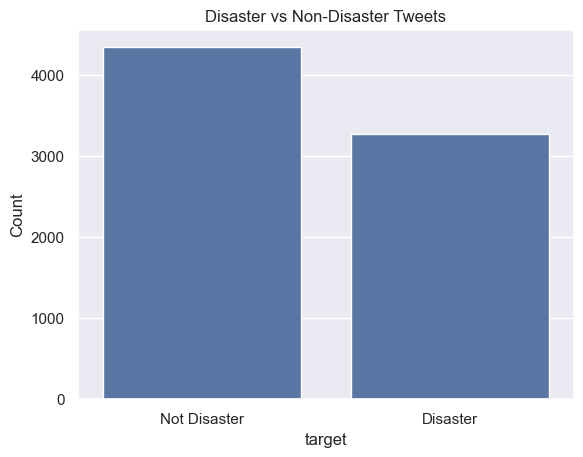

In [57]:
# Check Label Distribution
label_counts = train_df['target'].value_counts()
label_percent = train_df['target'].value_counts(normalize=True) * 100

print(pd.DataFrame({'Count': label_counts, 'Percentage': label_percent.round(2)}))

sns.countplot(data=train_df, x='target')
plt.title('Disaster vs Non-Disaster Tweets')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.ylabel('Count')
plt.show()

In [58]:
# Find missing values
missing_count = train_df.isnull().sum()
missing_percent = (missing_count / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent.round(2)
})

missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
keyword,61,0.80
location,2533,33.27


In [59]:
# Address missing values
# Fill missing keyword with unknown
train_df['keyword'] = train_df['keyword'].fillna('unknown')
# Drop location since it's missing in 33% of the dataset. It'll just add noise to the model
train_df = train_df.drop(columns=['location'])
train_df.head()

,id,keyword,text,target
0,1,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,All residents asked to 'shelter in place' are ...,1
3,6,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,unknown,Just got sent this photo from Ruby #Alaska as ...,1


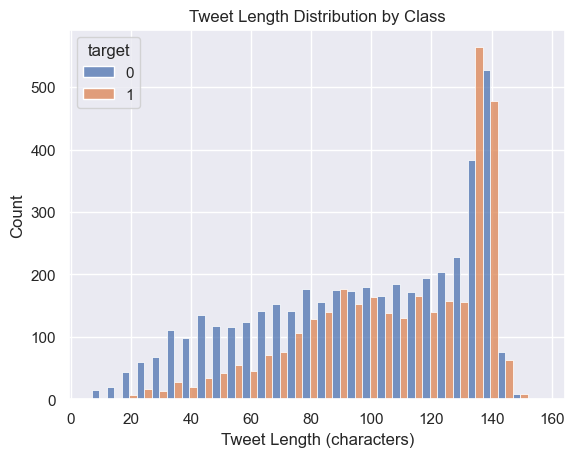

In [60]:
# Analyse Tweet length
train_df['text_len'] = train_df['text'].str.len()

sns.histplot(data=train_df, x='text_len', hue='target', bins=30, multiple='dodge')
plt.title('Tweet Length Distribution by Class')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.show()


Text(0.5, 1.0, 'Disaster Tweets WordCloud')

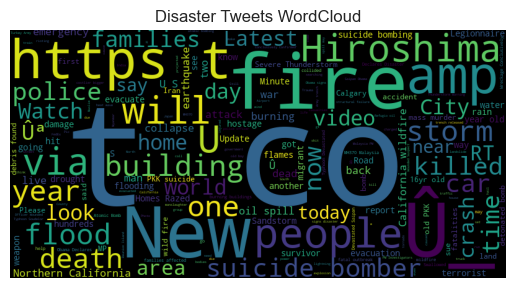

In [61]:
# Display word cloud for disaster tweets
text = ' '.join(train_df[train_df['target'] == 1]['text'])
plt.imshow(WordCloud(width=800, height=400).generate(text))
plt.axis('off')
plt.title("Disaster Tweets WordCloud")

In [62]:
# Find duplicate tweets
train_df.duplicated(subset='text').sum()

110

In [64]:
# Remove duplicate tweets if the label is consistent, keep one record
dupes = train_df[train_df.duplicated(subset='text', keep=False)]
print(dupes.groupby('text')['target'].nunique().value_counts())
consistent_texts = dupes.groupby('text')['target'].nunique()
consistent_texts = consistent_texts[consistent_texts == 1].index
train_df = train_df[~(train_df['text'].isin(consistent_texts) & train_df.duplicated(subset='text'))]

target
1    51
2    18
Name: count, dtype: int64


In [65]:
# Show remaining duplicates
train_df.duplicated(subset='text').sum()

37

In [69]:
# Remove duplicate tweets if the label is incosistent, remove all records
conflicting_texts = dupes.groupby('text')['target'].nunique()
conflicting_texts = conflicting_texts[conflicting_texts > 1].index
train_df = train_df[~train_df['text'].isin(conflicting_texts)]
train_df.duplicated(subset='text').sum()

0

## Model Architecture

### Text Processing: TF-IDF Embedding
I'll use TF-IDF (Term Frequency–Inverse Document Frequency) to convert the raw tweets into numerical vectors. TF-IDF represents each document (tweet) by the importance of words in that document relative to the entire dataset. 
- Term Frequency (TF) measures how often a word appears in a document.
- Inverse Document Frequency (IDF) downweights common words (like "the", "is") that appear in many tweets.
As a result, TF-IDF assigns higher weights to words that are important in a specific tweet but not common across the dataset.

### Neural Network Architecture

1. Input (TF-IDF vector, 10,000 dimensions)
2. Dense(128 units, ReLU activation)
3. Dropout(0.5)
4. Dense(64 units, ReLU activation)
5. Dropout(0.3)
6. Dense(1 unit, Sigmoid activation)

- **Dense Layers (Fully Connected):** Capture non-linear combinations of TF-IDF features.  
- **ReLU Activation:** Enables the model to learn complex decision boundaries.  
- **Dropout:** Regularization to prevent overfitting.  
- **Sigmoid Output:** Suitable for binary classification, outputs a probability between 0 and 1.

## Results and Analysis

In [71]:
# Split training data set => 20% test
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_df['text']).toarray()
y = train_df['target'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20)

In [74]:
# Build model
def build_model(hidden_layers=[128, 64], dropout_rates=[0.5, 0.3], learning_rate=1e-3):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rates[0]))

    for units, rate in zip(hidden_layers[1:], dropout_rates[1:]):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(rate))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])
    return model


In [76]:
# Hyperparameter tuning
experiments = []

configs = [
    {"name": "Model A", "layers": [128, 64], "dropouts": [0.5, 0.3]},
    {"name": "Model B", "layers": [256, 128], "dropouts": [0.3, 0.2]},
    {"name": "Model C", "layers": [128, 64, 32], "dropouts": [0.4, 0.3, 0.2]},
]
for config in configs:
    print(f"Training {config['name']}...")
    model = build_model(config['layers'], config['dropouts'])
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        verbose=0)
    preds = model.predict(X_val) > 0.5
    f1 = f1_score(y_val, preds)

    experiments.append({
        "name": config['name'],
        "model": model,
        "history": history,
        "f1": f1
    })

    print(f"{config['name']} → F1 Score: {f1:.4f}")


Training Model A...


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model A → F1 Score: 0.7059
Training Model B...


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model B → F1 Score: 0.6967
Training Model C...


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model C → F1 Score: 0.6894


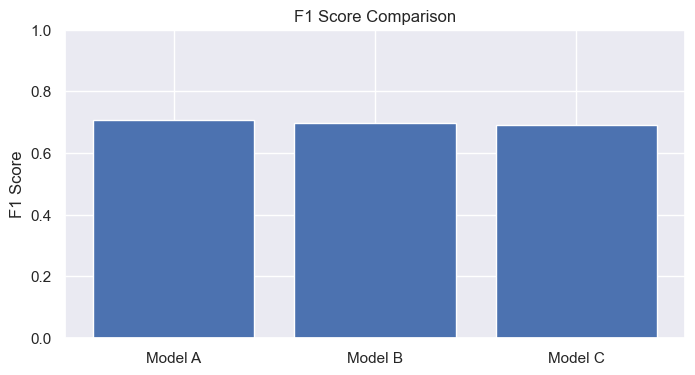

In [77]:
# Plot F1 Score Comparison
names = [e["name"] for e in experiments]
f1s = [e["f1"] for e in experiments]

plt.figure(figsize=(8, 4))
plt.bar(names, f1s)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison")
plt.ylim(0, 1)
plt.show()


## Conclusion

- Model A (simpler architecture) achieved the best F1 score: 0.7059. The moderate dropout (0.3–0.5) improved generalization
- Deeper networks in Model C led to overfitting while more hidden units in Model B didn't improve performance
- Adding complexity increased training time but did not improve performace

### Key Takeaways
- Simpler models can outperform deeper ones on smaller datasets
- Dropout is essential for avoiding overfitting

### Future Improvements
- Use pretrained embeddings + LSTM/GRU
